In [260]:
import pandas as pd
import math
import statsmodels.api as sm
import numpy as np

In [263]:
df = pd.read_excel('base_1D.xlsx', index_col='Data')

In [264]:
def calc_ret_ln(df):
    #Cria matriz para receber valores calculados
    df_ln = pd.DataFrame(columns = df.columns, index = df.index)

    #Calcula o ln para todos os valores
    for i in range(len(df)):
        for columns in df.columns:
            df_ln[columns][i] = math.log(df[columns][i])

    # Retorno diário     
    ret = df_ln - df_ln.shift(-1)

    return ret.dropna(), df_ln

In [265]:
retorno, df_ln = calc_ret_ln(df)

In [266]:
def reg_m(y, x):
    ones = np.ones(len(x))
    X = sm.add_constant(np.column_stack((x, ones)))
    for ele in x:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [321]:
df.head()

,WINFUT,WSPFUT,WDOFUT
Data,,,
2021-10-05,110300.0,4340.0,5501.0
2021-10-04,110400.0,4299.5,5481.0
2021-10-01,113120.0,4355.0,5387.0
2021-09-30,110690.0,4301.0,5467.5
2021-09-29,111140.0,4362.0,5436.5


In [461]:
periodo = 100
base = retorno

# Regressão

## Precos as is

In [462]:
y = np.array(base.WINFUT.iloc[:periodo], dtype = float)
x = np.array(base.iloc[:periodo,1:], dtype = float)

In [463]:
def reg_m(x,y):
    X = sm.add_constant(x)
    modelo = sm.OLS(y, X)
    modelo_v1 = modelo.fit()
    return modelo_v1

In [464]:
coef = reg_m(x,y).params

In [465]:
print(reg_m(x,y).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     43.58
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           3.14e-14
Time:                        02:11:04   Log-Likelihood:                 330.53
No. Observations:                 100   AIC:                            -655.1
Df Residuals:                      97   BIC:                            -647.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.388      0.1

In [466]:
import plotly.express as px

fig = plt.figure(figsize=(30,30))
fig = px.scatter_3d(base, x='WDOFUT', y='WSPFUT', z='WINFUT')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<Figure size 2160x2160 with 0 Axes>

# Resíduos

In [470]:
residuos = base.WINFUT-(coef[1]*base.WSPFUT + coef[0]*base.WDOFUT)

In [471]:
from statsmodels.tsa.stattools import adfuller

def coint_model(residuos):
    try:
        adfTest = adfuller(residuos, autolag='AIC')
        return {
            'ADF': adfTest,
        }
    except:
        raise

In [472]:
coint_model(residuos)['ADF']

(-10.778399130575535,
 2.28825755501594e-19,
 4,
 688,
 {'1%': -3.439890503006147,
  '5%': -2.865750085260771,
  '10%': -2.569011980884938},
 -3744.334198972296)

In [473]:
residuos = pd.DataFrame(columns=['residuos'])
residuos['residuos'] = reg_m(x,y).resid_pearson

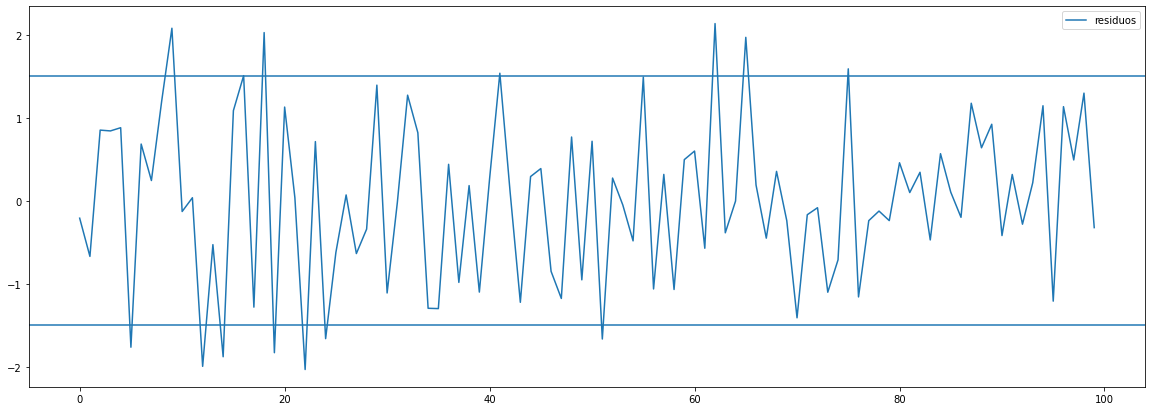

In [474]:
import matplotlib.pyplot as plt
residuos.plot(figsize=(20,7))
plt.axhline(y=1.5)
plt.axhline(y=-1.5)

# Meia Vida

In [475]:
def half_life(ts):
    lagged = ts.shift(1).fillna(method="bfill")
    delta = ts-lagged
    X = sm.add_constant(lagged.values)
    ar_res = sm.OLS(delta, X).fit()
    half_life = -1*np.log(2)/ar_res.params['x1']
    return half_life, ar_res, delta, lagged

half_life, ar_res, delta, lagged = half_life(residuos)
print('halflife: ', half_life)

halflife:  0.5610465281387941


In [476]:
def get_scatter_plot(series_x, series_y, ols):
    x = np.arange(series_x.values.min(), series_x.values.max())
    # limpa o canvas
    plt.clf()
    plt.cla()
    #mplt.close()
    plt.scatter(series_x, series_y)
    plt.plot(x, ols.params.const + ols.params.x1 * x, color='red')

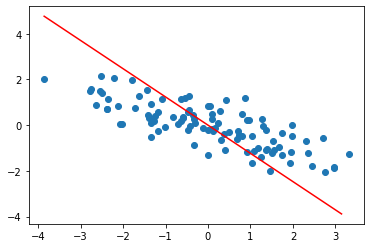

In [477]:
get_scatter_plot(delta, lagged, ar_res)

# Preditor

In [280]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 200)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [281]:
y_pred = regressor.predict(X_test)
print(y_pred)

[-0.01029565 -0.01573172 -0.02027437  0.00646258  0.01309615  0.01608009
  0.00025245  0.00950884 -0.02075139  0.00261566 -0.00194455 -0.00145496]


In [282]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.6081729831013999